# 0.4 Regression prototype

This notebook consists of the prototype regression code, using the auto insurance claims prototype data discussed in notebook 01.Exploration. The data in question has a 1000 rows, and has 38 features (excluding the target feature) and the target of this regression task is to predict the `total_claim_amount`. We simulate real-world workflows and use `TwedieeRegressor`, one of the standard GLM's for predicting insurance claim amounts. 

The benefits of TweedieRegressor in this context is that the model: 

* Can naturally model outcomes that are non-negative
* Can naturally model outcoumes that are right-skewed
* Can naturally model outcomes that are zero-inflated.

Insurance claim amounts are often non-negative, right-skewed(a few large claims) and zero-inflated (many claim amounts are zero). It is worth noting that the prototype data is quite unrealistic in that it only contains entries where there is a non-zero `total_claim_amount`, but we continue using `TweedieRegressor` in spite of this. In preparation of more realistic data.

## Import Statements and Setup

In [1]:
import os
print(os.getcwd())

c:\Users\phili\desktop\Insurance_Project\notebooks


In [2]:
from pathlib import Path
import sys
import os
# Path to project root
PROJECT_ROOT = Path.home()/ "Desktop" / "Insurance_Project"

# Add root to Python path
sys.path.append(str(PROJECT_ROOT))

# Change current directory

os.chdir(PROJECT_ROOT)



In [3]:
from pathlib import Path
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.models import regression as reg
%matplotlib inline
import os

In [4]:
print(os.getcwd())

C:\Users\phili\Desktop\Insurance_Project


## Loading the data from 02.preprocessing

We load the data which was split, imputed and scaled in `02.preprocessing`. We continue by also inspecting the distribution of the target feature `total_claim_amount`. Which we do by plotting a histogram of the target feature

In [5]:
data_folder = Path.cwd()/"data"/"processed"
X_train = pd.read_csv(data_folder/"reg"/"X_train.csv")
X_test = pd.read_csv(data_folder/"reg"/"X_test.csv")
y_train = pd.read_csv(data_folder/"reg"/"y_train.csv")
y_test = pd.read_csv(data_folder/"reg"/"y_test.csv")

### Plotting Histogram of `total_claim_amount`

We plot a histogram of `total_claim_amount` by using seaborns `histplot()`. We can observe that the target feature has a mixed distribution, where the distribution is a multimodal distribution resembling a *Poisson-distribution* and a *Gamma-distribution*

In [6]:
y_plot = y_train.reset_index(drop=True).squeeze()


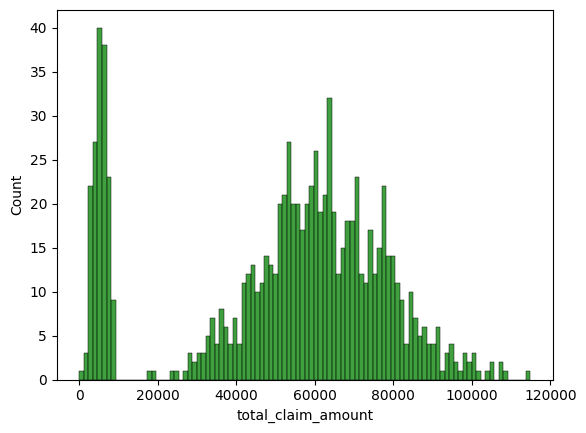

In [7]:
reg.find_dist_h(y_plot)

## Using Cross-Validation for hyperparameter optimization

We use scikit-learns `GridSearchCV` in order to implement Cross-Validation, where we try to optimize the `power` (which determines the distribution the estimator should assume) and `alpha` (which determines the L2-regularization in order to prevent overfitting). Our cross-validation is implemented on 90% of the data, and 10 % is reserved for a final evaluation of the best model found during cross-validation. The Cross-Validation algorithm is meant to optimize the *Mean Absolute Error (MAE)* of the regression model, and uses 5 stratified K-Folds. 

In [8]:
import sklearn
import sklearn.model_selection
print(sklearn.__file__)
print(sklearn.__version__)
print(sklearn.model_selection.GridSearchCV)


c:\Users\phili\Environments\ds_env\Lib\site-packages\sklearn\__init__.py
1.7.2
<class 'sklearn.model_selection._search.GridSearchCV'>


In [9]:

best_model, best_params, best_mae = reg.CV_optimize(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


## Evaluating the optimized model found via Cross-Validation

We measure the performance of the best estimator found by `GridSearchCV`, and use the following metrics as measurements of its performance:

* *Mean Absolute Error (MAE)*
* *Mean Squared Error (MSE)*
* *Root Mean Squared Error (RMSE)* 
* *Mean Absolute Percentage Error (MAPE)*
* *R2-Score (R2)*

We also save the model to `.pkl` file, and observe the best parameters found by `GridSearchCV`

In [16]:
print(f"BEST Tweedie_Deviance after CV: {best_mae}")
print(f"Best_params: {best_params}")

BEST Tweedie_Deviance after CV: 100.14598766796654
Best_params: {'alpha': 1.0, 'power': np.float64(1.8000000000000007)}


### Saving & Loading the model as a `.pkl`-file

The reason we load the model after having initalised it during `optimizeCV` is because we want to avoid having to run that specific cell unless absolutely necessary, because of its runtime.

In [11]:
import joblib

joblib.dump(best_model, PROJECT_ROOT/"models"/"regression"/"tweedie_model.pkl")

['C:\\Users\\phili\\Desktop\\Insurance_Project\\models\\regression\\tweedie_model.pkl']

In [12]:
import joblib

best_model = joblib.load(PROJECT_ROOT/"models"/"regression"/"tweedie_model.pkl")

### Interpreting the performance of the regression model

We see the performance of the model. A quick interpretation of the result tells us that the model has an average error of around $5320.9 (which seems reasonable given the fact that `total_claim_amounts` range in the tens of thousands), or alternatively: The model deviates, on average, by 19.6% when predicting values as compared to the actual values. We can furthermore see that around 90% of the variance in the data is explained by the regression model. 

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error
y_pred_test = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
mape = mean_absolute_percentage_error(y_test, y_pred_test)

metrics = {
    'mse':mse,
    'rmse':rmse,
    'mae':mae,
    'mape':mape,
    'r2':r2
}

for key, item in metrics.items():
    print(f"{key.upper()} -- {item}")


MSE -- 687362522.1336448
RMSE -- 26217.599473133403
MAE -- 20416.257745736824
MAPE -- 1.6941405191048895
R2 -- 0.013709969237086228


## Plotting the actual vs predicted errors

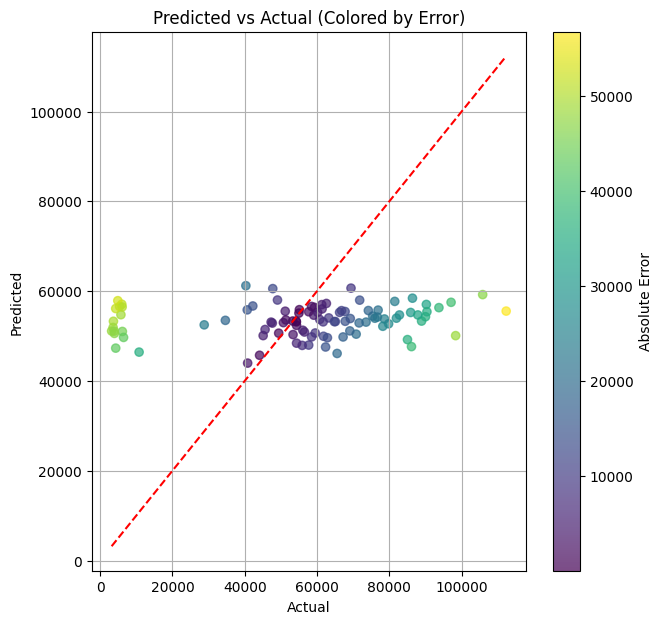

In [14]:
#Prepping the target vectors for plotting
y_pred = y_pred_test
y_test = y_test.values.ravel()
# Computing a vector of the absolute errors
errors = np.abs(y_test - y_pred)

#Plotting the figure
plt.figure(figsize=(7, 7))
# Implementing scatter of y_test and y_pred, which is color coordinated depending on error
plt.scatter(y_test, y_pred, c=errors, cmap="viridis", alpha=0.7)
plt.colorbar(label="Absolute Error")

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Colored by Error)")
plt.grid(True)
plt.show()


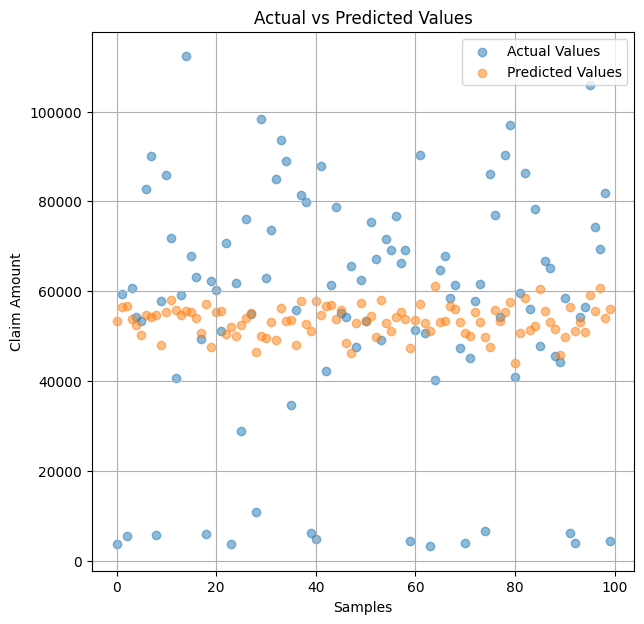

In [15]:
plt.figure(figsize=(7, 7))

plt.scatter(range(len(y_test)), y_test, alpha=0.5, label="Actual Values")
plt.scatter(range(len(y_pred)), y_pred, alpha=0.5, label="Predicted Values")

plt.xlabel("Samples")
plt.ylabel("Claim Amount")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()